In [29]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [30]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [31]:
# load the whole dataset into RAM
labels = np.load("dataset/sprite_labels_nc_1788_16x16.npy")
data = np.load("dataset/sprites_1788_16x16.npy")

print("Shape: ", data.shape)

images_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Convert HWC -> CHW
print("Shape (before permute): ", images_tensor.shape)
images_tensor = images_tensor.permute(0, 3, 1, 2)
print("Shape (after permute): ", images_tensor.shape)

dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Device: ", device)

Shape:  (89400, 16, 16, 3)
Shape (before permute):  torch.Size([89400, 16, 16, 3])
Shape (after permute):  torch.Size([89400, 3, 16, 16])
Device:  cuda:0


In [32]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

# Get one batch from the DataLoader
real_batch = next(iter(loader))  # real_batch[0]: images, real_batch[1]: labels

real_batch = next(iter(loader))
images, labels = real_batch
print(images.shape, labels.shape)

torch.Size([32, 3, 16, 16]) torch.Size([32, 5])


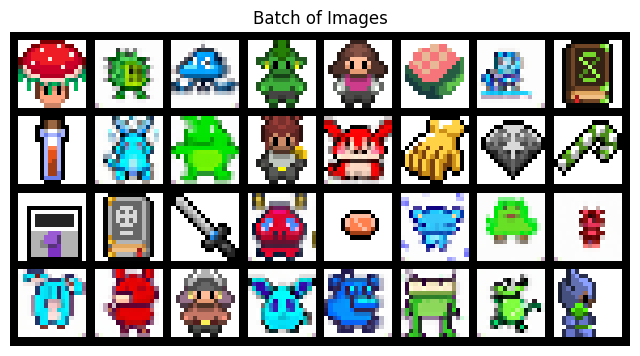

In [ ]:
grid = vutils.make_grid(
    images,
    padding=2,
    normalize=True
)

'''
C: channels
H: height
W: width
B: batch size
'''
# CHW -> HWC for matplotlib
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Batch of Images")
plt.imshow(grid.numpy())
plt.show()

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)